In [182]:
import pandas as pd
import adata

etfs = ['513500', '510300', '511260'] 

df = pd.DataFrame()

for i in etfs:
    etf_df = adata.fund.market.get_market_etf(i, start_date='2018-01', end_date='2024-12', k_type=1)
    etf_df['close'] = etf_df['close'].astype(float)
    pivot_df = etf_df.pivot(index='trade_date', columns='fund_code', values='close')
    df = pd.concat([df, pivot_df], axis=1)

change_df = df.pct_change().dropna()
change_df

/tmp/ipykernel_192627/1577698189.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  change_df = df.pct_change().dropna()


fund_code,513500,510300,511260
trade_date,,,
2018-01-03,0.004914,0.005964,-0.000407
2018-01-04,0.001222,0.003503,0.000010
2018-01-05,0.001221,0.004296,-0.000846
2018-01-08,0.007317,0.004545,-0.000938
2018-01-09,0.000000,0.009050,0.001408
...,...,...,...
2024-11-26,0.001837,-0.002035,0.001319
2024-11-27,-0.000459,0.016314,-0.000946
2024-11-28,-0.000917,-0.007274,0.001432


83

In [167]:
import numpy as np
from arch import arch_model
from scipy.optimize import minimize


def forecast_volatility(returns, p=1, q=1, horizon=3):
    model = arch_model(returns, vol='GARCH', p=p, q=q, rescale=False)
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=horizon)
    monthly_vol = np.sqrt(forecast.variance.iloc[-1].mean())
    return (monthly_vol * np.sqrt(12)) # 年化月度波动率

def objective(weights, vol_pred, corr_matrix, target_vol):
    # 计算协方差矩阵
    cov_matrix = np.diag(vol_pred) @ corr_matrix @ np.diag(vol_pred)
    # 计算组合波动率
    portfolio_vol = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))
    return np.abs(portfolio_vol - target_vol)

def constraint(weights):
    return np.sum(weights) - 1

def optimize_weights(vol_pred, corr_matrix, target_vol, min_weight=0.05):
    n_assets = len(vol_pred)
    initial_weights = np.array([1/n_assets] * n_assets)
    bounds = tuple((min_weight, 1) for _ in range(n_assets))
    constraints = ({'type': 'eq', 'fun': constraint})
    result = minimize(objective, initial_weights, args=(vol_pred, corr_matrix, target_vol), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def target_volatility_strategy(returns, target_vol, min_weight=0.05, lookback=60):
    n_assets = returns.shape[1]
    weights = np.zeros((len(returns), n_assets))
    
    # 创建一个日期索引
    dates = returns.index
    
    for t in range(lookback, len(returns)):
        historical_returns = returns.iloc[t-lookback:t]
        vol_pred = np.array([forecast_volatility(historical_returns[col]) for col in historical_returns.columns])
        corr_matrix = historical_returns.corr()
        optimized_weights = optimize_weights(vol_pred, corr_matrix, target_vol, min_weight)
        weights[t] = optimized_weights
    
    # 创建一个 DataFrame，索引为日期，列名为资产名称
    weights_df = pd.DataFrame(weights[lookback:], index=dates[lookback:], columns=returns.columns)
    # 保留小数点后两位
    weights_df = weights_df.round(2)
    
    strategy_returns = (weights_df * returns.iloc[lookback:]).sum(axis=1)
    
    return strategy_returns, weights_df

def equal_weight_strategy(returns):
    n_assets = returns.shape[1]
    weights = np.ones((len(returns), n_assets)) * (1 / n_assets)  # 等权重分配
    
    # 创建一个日期索引
    dates = returns.index
    
    # 创建一个 DataFrame，索引为日期，列名为资产名称
    weights_df = pd.DataFrame(weights, index=dates, columns=returns.columns)
    
    # 计算策略收益
    strategy_returns = (weights_df * returns).sum(axis=1)
    
    return strategy_returns, weights_df


def performance_metrics(strategy_returns):
    # 总回报
    total_return = (1 + strategy_returns).prod() - 1
    
    # 波动率（年化）
    volatility = strategy_returns.std() * np.sqrt(12)  # 假设有252个交易日

    # 夏普比率（假设无风险利率为0）
    sharpe_ratio = total_return / volatility if volatility != 0 else 0
    
    # 最大回撤
    cumulative_returns = (1 + strategy_returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    return pd.Series({
        "Total Return": total_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    })

In [284]:
lookback_p = 12
strategy_returns, weights_df = target_volatility_strategy(change_df, target_vol=0.05,  min_weight=0, lookback=lookback_p)
eq_strategy_returns, eq_weights_df = equal_weight_strategy(change_df.iloc[lookback_p:])

/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/conda/lib/python3.12/site-packag

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算净值
initial_value = 1.0  # 初始净值
net_value = (1 + strategy_returns).cumprod() * initial_value
net_value.index = pd.to_datetime(net_value.index)


initial_value = 1.0  # 初始净值
eq_net_value = (1 + eq_strategy_returns).cumprod() * initial_value
eq_net_value.index = pd.to_datetime(eq_net_value.index)

start_date = max(net_value.index[0], eq_net_value.index[0])
net_value = net_value[net_value.index >= start_date]
eq_net_value = eq_net_value[eq_net_value.index >= start_date]

# 绘制净值曲线
plt.figure(figsize=(12, 6))
plt.plot(net_value.index, net_value, label='target vol + garch', color='blue')
plt.plot(eq_net_value.index, eq_net_value, label='Eq weight', color='black')
plt.title('Strategy Net Value')
plt.xlabel('日期')
plt.ylabel('净值')
plt.axhline(y=1, color='r', linestyle='--', label='initial value (1.0)')
plt.legend()
plt.grid()
plt.show()

print("目标波动率-指标")
display(performance_metrics(strategy_returns))

print("等权-指标")
performance_metrics(eq_strategy_returns)

In [180]:
def cvar_objective(weights, returns, alpha=0.05):
    # 计算投资组合的日收益率
    portfolio_returns = returns @ weights
    
    # 计算VaR
    VaR = np.percentile(portfolio_returns, 100 * alpha)
    
    # 计算超出VaR的损失
    exceedances = portfolio_returns[portfolio_returns < VaR]
    
    # 计算CVaR
    if len(exceedances) > 0:
        CVaR = -np.mean(exceedances)
    else:
        CVaR = -VaR  # 如果没有超出VaR的损失，CVaR等于VaR

    # 年化CVaR
    annualized_CVaR = CVaR * np.sqrt(12)
    
    return annualized_CVaR

def cvar_optimization(returns, alpha=0.05):
    n_assets = returns.shape[1]
    
    # 初始权重（均匀分布）
    initial_weights = np.ones(n_assets) / n_assets
    
    # 定义约束条件
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # 权重之和为1
    )
    
    # 定义边界条件（权重非负）
    bounds = [(0, 1) for _ in range(n_assets)]
    
    # 使用minimize进行优化
    result = minimize(
        cvar_objective, 
        initial_weights, 
        args=(returns, alpha), 
        method='SLSQP', 
        constraints=constraints, 
        bounds=bounds
    )
    
    # 返回最优权重
    return pd.Series(result.x, index=returns.columns)

cvar_optimization(change_df)

fund_code
513500    0.121897
510300    0.017758
511260    0.860344
dtype: float64

In [ ]:
p_df = df.iloc[::-20].iloc[::-1]
p_df = p_df.dropna()

## for i in loop p_df
##  returns = df[i-200:i] (need convert here)
##  weight = cvar_optimization(returns)
### strategy_returns = (weights_df * returns).sum(axis=1)

### plot net value via strategy_returns

/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/conda/lib/python

Net Value Over Time:
 trade_date
2022-09-07    0.999646
2022-09-08    0.999748
2022-09-09    1.001003
2022-09-13    1.001459
2022-09-14    0.997833
                ...   
2024-10-29    1.099358
2024-10-30    1.098555
2024-10-31    1.098116
2024-11-01    1.099099
2024-11-04    1.100476
Length: 520, dtype: float64


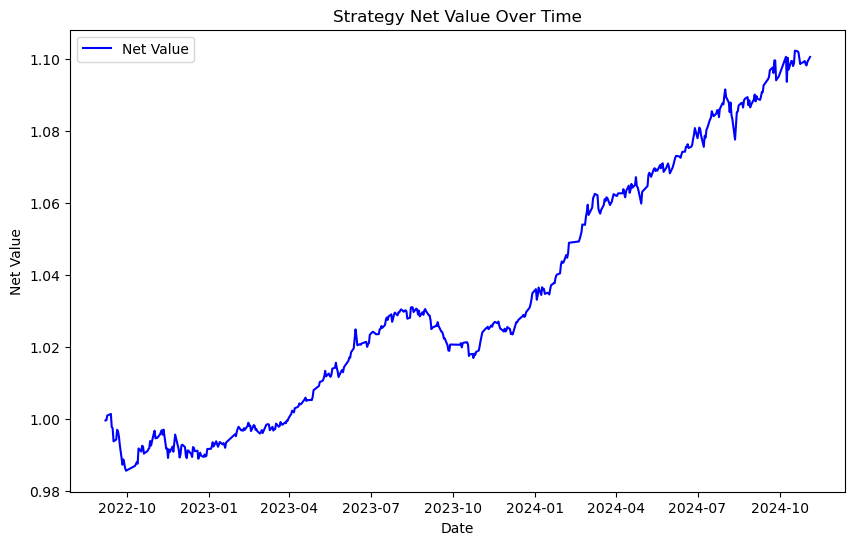

Total Return     0.100476
Volatility       0.004849
Sharpe Ratio    20.719683
Max Drawdown    -0.015727
dtype: float64

In [281]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 获取历史价格数据（假设你已经有了这个DataFrame）
# df = get_historical_prices(tickers, start_date, end_date)

def calculate_returns(prices):
    return prices.pct_change().dropna()

def fit_garch_model(returns, p=1, q=1):
    """Fit a GARCH(p, q) model to the returns and predict volatility."""
    garch = arch_model(returns, vol='Garch', p=p, q=q, rescale=False)
    res = garch.fit(disp='off')
    forecast = res.forecast(horizon=1)
    return forecast.variance.iloc[-1].values[0] ** 0.5  # 返回下一个时期的预测波动率

def cvar_optimization(returns, alpha=0.05):
    n_assets = returns.shape[1]
    initial_weights = np.ones(n_assets) / n_assets
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    bounds = [(0.05, 1) for _ in range(n_assets)]
    
    def cvar_objective(weights):
        portfolio_returns = returns @ weights
        VaR = np.percentile(portfolio_returns, 100 * alpha)
        exceedances = portfolio_returns[portfolio_returns < VaR]
        if len(exceedances) > 0:
            CVaR = -np.mean(exceedances)
        else:
            CVaR = -VaR
        return CVaR
    
    result = minimize(cvar_objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
    return pd.Series(result.x, index=returns.columns)

def backtest_strategy(df, window_size=200, period=20, alpha=0.05):
    # 提取月度数据点
    p_df = df.iloc[::-period].iloc[::-1].dropna()
    
    all_daily_returns = []  # 保存所有窗口的每日回报
    weights_list = []  # 保存每期的权重
    vol_forecasts = []  # 保存每个窗口的波动率预测
    
    start_at = max(0, len(p_df) - len(df) // window_size)
    for i in range(start_at, len(p_df) - 1):
        current_date = p_df.index[i]
        
        # 获取过去window_size天的收益率数据
        start_idx = df.index.get_loc(current_date) - window_size + 1
        if start_idx < 0:
            continue
        
        historical_data = df.iloc[start_idx:start_idx + window_size]
        returns = calculate_returns(historical_data)
        
        # 进行CVaR组合优化
        weights = cvar_optimization(returns, alpha=alpha)
        weights = weights.round(2)
        weights_list.append(weights)  # 保存权重
        
        # 计算下一个period天的策略回报
        if (i + 1) > len(p_df):
            break
        next_date = p_df.index[i + 1]
        next_period_data = df.loc[current_date:next_date]
        next_period_returns = calculate_returns(next_period_data)
        
        if not next_period_returns.empty:
            daily_returns = (weights * next_period_returns).sum(axis=1)
            all_daily_returns.append(daily_returns)
            
    # 一次性计算净值
    all_daily_returns_df = pd.concat(all_daily_returns)
    net_value_series = (1 + all_daily_returns_df).cumprod()
    weight_df = pd.DataFrame(weights_list, columns=df.columns)
    
    return net_value_series, all_daily_returns_df, weight_df

e_df = df.copy()
e_df.index = pd.to_datetime(e_df.index)
    # 回测策略
net_value, all_daily_returns_df, weight_df = backtest_strategy(e_df, window_size=60, period=20, alpha=0.2)
# 打印结果
print("Net Value Over Time:\n", net_value)
# 绘制净值曲线
plt.figure(figsize=(10, 6))
plt.plot(net_value, label='Net Value', color='blue')
plt.title('Strategy Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

performance_metrics(all_daily_returns_df)

In [303]:
e_df

fund_code,513500,510300,511260
trade_date,,,
2018-01-02,0.814,3.689,98.200
2018-01-03,0.818,3.711,98.160
2018-01-04,0.819,3.724,98.161
2018-01-05,0.820,3.740,98.078
2018-01-08,0.826,3.757,97.986
...,...,...,...
2024-11-26,2.181,3.923,132.100
2024-11-27,2.180,3.987,131.975
2024-11-28,2.178,3.958,132.164


/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/conda/lib/python

Net Value Over Time:
 trade_date
2022-10-12    1.011736
2022-10-13    1.003472
2022-10-14    1.029360
2022-10-17    1.021444
2022-10-18    1.033489
                ...   
2024-11-25    1.467664
2024-11-26    1.467481
2024-11-27    1.479079
2024-11-28    1.473195
2024-11-29    1.482496
Length: 520, dtype: float64


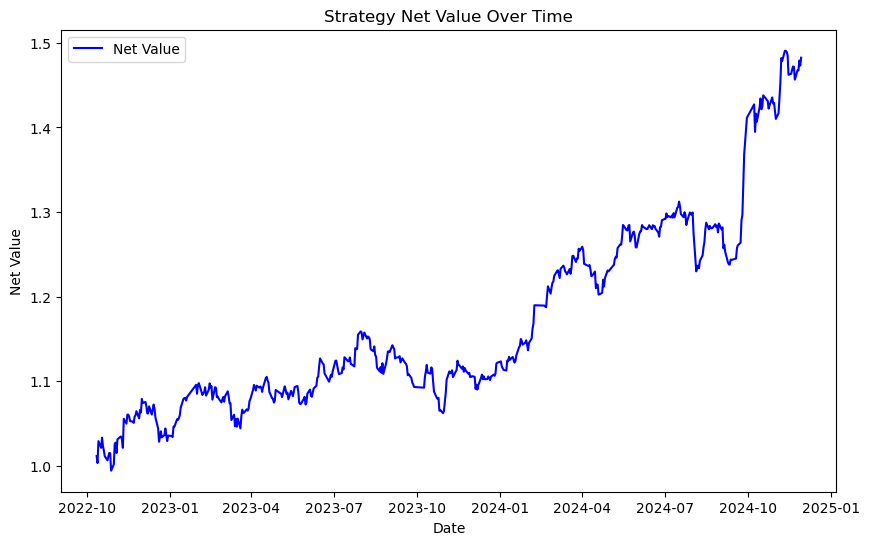

Total Return     0.482496
Volatility       0.025633
Sharpe Ratio    18.823111
Max Drawdown    -0.083420
dtype: float64

In [311]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 获取历史价格数据（假设你已经有了这个DataFrame）
# df = get_historical_prices(tickers, start_date, end_date)

def calculate_returns(prices):
    return prices.pct_change().dropna()

def fit_garch_model(returns, p=2, q=1):
    """Fit a GARCH(p, q) model to the returns and predict volatility for each asset."""
    vol_forecasts = []
    for asset in returns.columns:
        garch = arch_model(returns[asset].values, vol='Garch', p=p, q=q, rescale=False, dist='t')
        res = garch.fit(disp='off')
        forecast = res.forecast(horizon=1)
        vol_forecasts.append(forecast.variance.iloc[-1].values[0] ** 0.5)  # 返回下一个时期的预测波动率
    return vol_forecasts
    
def cvar_optimization(returns, log_returns, alpha=0.05, target_vol=0.05):
    n_assets = returns.shape[1]
    initial_weights = np.ones(n_assets) / n_assets
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # 权重和为1
    ]
    bounds = [(0.05, 1) for _ in range(n_assets)]

    vol_pred = fit_garch_model(log_returns)

    # 添加波动率约束
    def volatility_constraint(weights):
        if vol_pred is not None:
            # 使用波动率预测计算组合波动率
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(np.diag(np.array(vol_pred)), weights)))
        else:
            # 使用历史波动率计算组合波动率
            portfolio_volatility = np.std(returns @ weights)
        return portfolio_volatility - target_vol
    constraints.append({'type': 'eq', 'fun': volatility_constraint})

    def cvar_objective(weights):
        portfolio_returns = returns @ weights
        VaR = np.percentile(portfolio_returns, 100 * alpha)
        exceedances = portfolio_returns[portfolio_returns < VaR]
        if len(exceedances) > 0:
            CVaR = -np.mean(exceedances)
        else:
            CVaR = -VaR
        return CVaR
    
    result = minimize(cvar_objective, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)
    return pd.Series(result.x, index=returns.columns)

def backtest_strategy(df, window_size=200, period=20, alpha=0.05, target_vol=0.05):
    # 提取月度数据点
    p_df = df.iloc[::-period].iloc[::-1].dropna()
    
    all_daily_returns = []  # 保存所有窗口的每日回报
    weights_list = []  # 保存每期的权重
    vol_forecasts = []  # 保存每个窗口的波动率预测
    
    start_at = max(0, len(p_df) - len(df) // window_size)
    for i in range(start_at, len(p_df) - 1):
        current_date = p_df.index[i]
        
        # 获取过去window_size天的收益率数据
        start_idx = df.index.get_loc(current_date) - window_size + 1
        if start_idx < 0:
            continue
        
        historical_data = df.iloc[start_idx:start_idx + window_size]
        returns = calculate_returns(historical_data)
        
        log_returns = np.log(historical_data / historical_data.shift(1))
        log_returns = log_returns.dropna()
        
        # 进行CVaR组合优化
        weights = cvar_optimization(returns, log_returns=log_returns, alpha=alpha, target_vol=target_vol)
        weights = weights.round(2)
        weights_list.append(weights)  # 保存权重
        
        # 计算下一个period天的策略回报
        if (i + 1) > len(p_df):
            break
        next_date = p_df.index[i + 1]
        next_period_data = df.loc[current_date:next_date]
        next_period_returns = calculate_returns(next_period_data)
        
        if not next_period_returns.empty:
            daily_returns = (weights * next_period_returns).sum(axis=1)
            all_daily_returns.append(daily_returns)
            
    # 一次性计算净值
    all_daily_returns_df = pd.concat(all_daily_returns)
    net_value_series = (1 + all_daily_returns_df).cumprod()
    weight_df = pd.DataFrame(weights_list, columns=df.columns)
    
    return net_value_series, all_daily_returns_df, weight_df

e_df = df.copy()
e_df.index = pd.to_datetime(e_df.index)
    # 回测策略
net_value, all_daily_returns_df, weight_df = backtest_strategy(e_df.dropna(), window_size=60, period=20, alpha=0.05)
# 打印结果
print("Net Value Over Time:\n", net_value)
# 绘制净值曲线
plt.figure(figsize=(10, 6))
plt.plot(net_value, label='Net Value', color='blue')
plt.title('Strategy Net Value Over Time')
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.legend()
plt.show()

performance_metrics(all_daily_returns_df)

In [273]:
weight_df

fund_code,513500,510300,511260
0,0.05,0.05,0.90
1,0.11,0.68,0.21
2,0.15,0.67,0.18
3,0.11,0.58,0.31
4,0.71,0.18,0.11
5,0.05,0.05,0.90
6,0.05,0.05,0.90
7,0.15,0.39,0.46
8,0.05,0.05,0.90
9,0.36,0.23,0.42
